In [1]:
# basic python packages
import numpy as np
import pandas as pd
import os
import sys 

# plotting
from matplotlib import pyplot as plt 
import seaborn as sns 
import scipy.stats as stats

# singlecell packages
import scanpy as sc
import anndata
import memento

#sc.settings.set_figure_params(dpi=500, dpi_save=1000, figsize=(5,5), facecolor='white')

In [2]:
# set the project directory 
os.chdir('/home/groups/singlecell/smorabito/analysis/SERPENTINE/clustering/Tcells')
data_dir = 'data/'
fig_dir = 'figures/'

In [3]:
# re-load the final dataset
cur_celltype = 'Tcells'
adata = sc.read_h5ad('{}/{}_integrated.h5ad'.format(data_dir, cur_celltype))

## Following Memento tutorial 

https://nbviewer.org/github/yelabucsf/scrna-parameter-estimation/blob/master/tutorials/binary_testing.ipynb


Also should actually read this paper to understand what memento is doing

Just as a test, let's compare MSI vs MSS within one of the Mets

In [4]:
# subset Lung Mets at the initial timepoint
# adata_test = adata[(adata.obs.Tissue == 'Lung met') & (adata.obs.Timepoint == 1)].copy()

In [5]:
# set the .X to the raw counts
# adata_test.X = adata_test.layers['counts'].copy()

In [6]:
# format the trait (MSS vs MSI) as a binary variable, as requested in the tutorial
# adata_test.obs['test'] = adata_test.obs['Microsatellite_status'].apply(lambda x: 0 if x == 'MSS' else 1)


In [7]:
# result_1d = memento.binary_test_1d(
#     # adata=adata_test,
#     capture_rate=0.25, # this is different for different chemistry
#     treatment_col='test', 
#     num_cpus=10,
#     num_boot=5000,
#     replicates = ['Replicate']
# )

In [8]:
# result_1d['log_de_pval'] = -1 * np.log10(result_1d['de_pval'])
# result_1d['log_dv_pval'] = -1 * np.log10(result_1d['dv_pval'])

## Updated approach in response to GitHub issue

https://github.com/yelabucsf/scrna-parameter-estimation/issues/40

Also, follow this tutorial for replicates: https://nbviewer.org/github/yelabucsf/scrna-parameter-estimation/blob/master/tutorials/binary_testing_replicates.ipynb


In [9]:
# subset Lung Mets at the initial timepoint
adata_test = adata[(adata.obs.Tissue == 'Lung met') & (adata.obs.Timepoint == 1)].copy()

# set the .X to the raw counts
adata_test.X = adata_test.layers['counts'].copy()

In [10]:
# format the trait (MSS vs MSI) as a binary variable, as requested in the tutorial
adata_test.obs['test'] = adata_test.obs['Microsatellite_status'].apply(lambda x: 0 if x == 'MSS' else 1)


In [11]:
? memento.ht_1d_moments

Signature:
 memento.ht_1d_moments(
    adata,
    treatment,
    covariate=None,
    treatment_for_gene=None,
    covariate_for_gene=None,
    inplace=True,
    num_boot=10000,
    verbose=1,
    num_cpus=1,
    **kwargs,
)
Docstring: Performs hypothesis testing for 1D moments.
File:      ~/.conda/envs/scanpy-081124/lib/python3.9/site-packages/memento/main.py
Type:      function


In [12]:
# options
THRESH = 0.02 # 0.07 by default
adata_test.obs['capture_rate'] = 0.25
treatment_col = 'test'
replicate_col = 'Replicate'
num_boot = 5000
num_cpus = 16
verbose = True

# additional setup for memento
memento.setup_memento(adata_test, q_column='capture_rate', filter_mean_thresh=THRESH)
memento.create_groups(adata_test, label_columns=[treatment_col, replicate_col])
memento.compute_1d_moments(adata_test, min_perc_group=.9)
sample_meta = memento.get_groups(adata_test)
sample_meta[replicate_col] = sample_meta[replicate_col].astype('category')
sample_meta.head()

/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/memento/main.py:181: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


,test,Replicate
sg^1^SPE_1_04_SCR_A_FRESH_1,1,SPE_1_04_SCR_A_FRESH_1
sg^1^SPE_1_04_SCR_A_FRESH_2,1,SPE_1_04_SCR_A_FRESH_2
sg^0^SPE_1_17_SCR_A_FRESH,0,SPE_1_17_SCR_A_FRESH
sg^0^SPE_1_20_SCR_A_FRESH_CD45neg,0,SPE_1_20_SCR_A_FRESH_CD45neg
sg^0^SPE_1_20_SCR_A_FRESH_CD45pos,0,SPE_1_20_SCR_A_FRESH_CD45pos


In [13]:
treatment_df = sample_meta[[treatment_col]]
cov_df = pd.get_dummies(sample_meta[replicate_col].astype('category'))
cov_df.head()

,SPE_1_04_SCR_A_FRESH_1,SPE_1_04_SCR_A_FRESH_2,SPE_1_17_SCR_A_FRESH,SPE_1_20_SCR_A_FRESH_CD45neg,SPE_1_20_SCR_A_FRESH_CD45pos
sg^1^SPE_1_04_SCR_A_FRESH_1,True,False,False,False,False
sg^1^SPE_1_04_SCR_A_FRESH_2,False,True,False,False,False
sg^0^SPE_1_17_SCR_A_FRESH,False,False,True,False,False
sg^0^SPE_1_20_SCR_A_FRESH_CD45neg,False,False,False,True,False
sg^0^SPE_1_20_SCR_A_FRESH_CD45pos,False,False,False,False,True


In [14]:
# run the test
memento.ht_1d_moments(
	adata_test, 
    treatment=treatment_df,
    covariate=cov_df,
    num_boot=num_boot, 
	verbose=verbose,
	num_cpus=num_cpus)
result_1d = memento.get_1d_ht_result(adata_test)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    9.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   22.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:   43.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  1.3min
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:  2.0min
[Parallel(n_jobs=16)]: Done 1768 tasks      | elapsed:  2.8min
[Parallel(n_jobs=16)]: Done 2418 tasks      | elapsed:  3.7min
[Parallel(n_jobs=16)]: Done 3168 tasks      | elapsed:  4.8min
[Parallel(n_jobs=16)]: Done 4018 tasks      | elapsed:  6.0min
[Parallel(n_jobs=16)]: Done 4968 tasks      | elapsed:  7.3min
[Parallel(n_jobs=16)]: Done 6018 tasks      | elapsed:  8.9min
[Parallel(n_jobs=16)]: Done 7168 tasks      | elapsed: 10.5min
[Parallel(n_jobs=16)]: Done 8418 tasks      | elapsed: 12.2min
[Parallel(n_jobs=16)]: Done 8509 out of 8509 | elapsed: 12.4min finished


In [15]:
result_1d['log_de_pval'] = -1 * np.log10(result_1d['de_pval'])
result_1d['log_dv_pval'] = -1 * np.log10(result_1d['dv_pval'])

In [16]:
result_1d.head()

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,log_de_pval,log_dv_pval
0,LINC01128,test,-0.777607,0.266132,2.999400e-03,0.265627,0.393992,0.522096,2.522966,0.282250
1,NOC2L,test,-0.142434,0.175010,6.252749e-01,0.544980,0.301507,0.078784,0.203929,1.103561
2,ISG15,test,-5.922377,0.229089,7.571986e-09,-3.871939,0.427541,0.000001,8.120790,5.977624
3,C1orf159,test,-0.818399,0.319714,2.619476e-02,-0.594465,0.485605,0.231754,1.581786,0.634973
4,TNFRSF18,test,2.797830,0.326034,8.991731e-05,1.997178,0.383683,0.000531,4.046157,3.274975


## Make a volcano plot showing the results

I should definitely make this volcano plot code into a function.

Also, should add an option to plot the mean or the variance results from Memento.

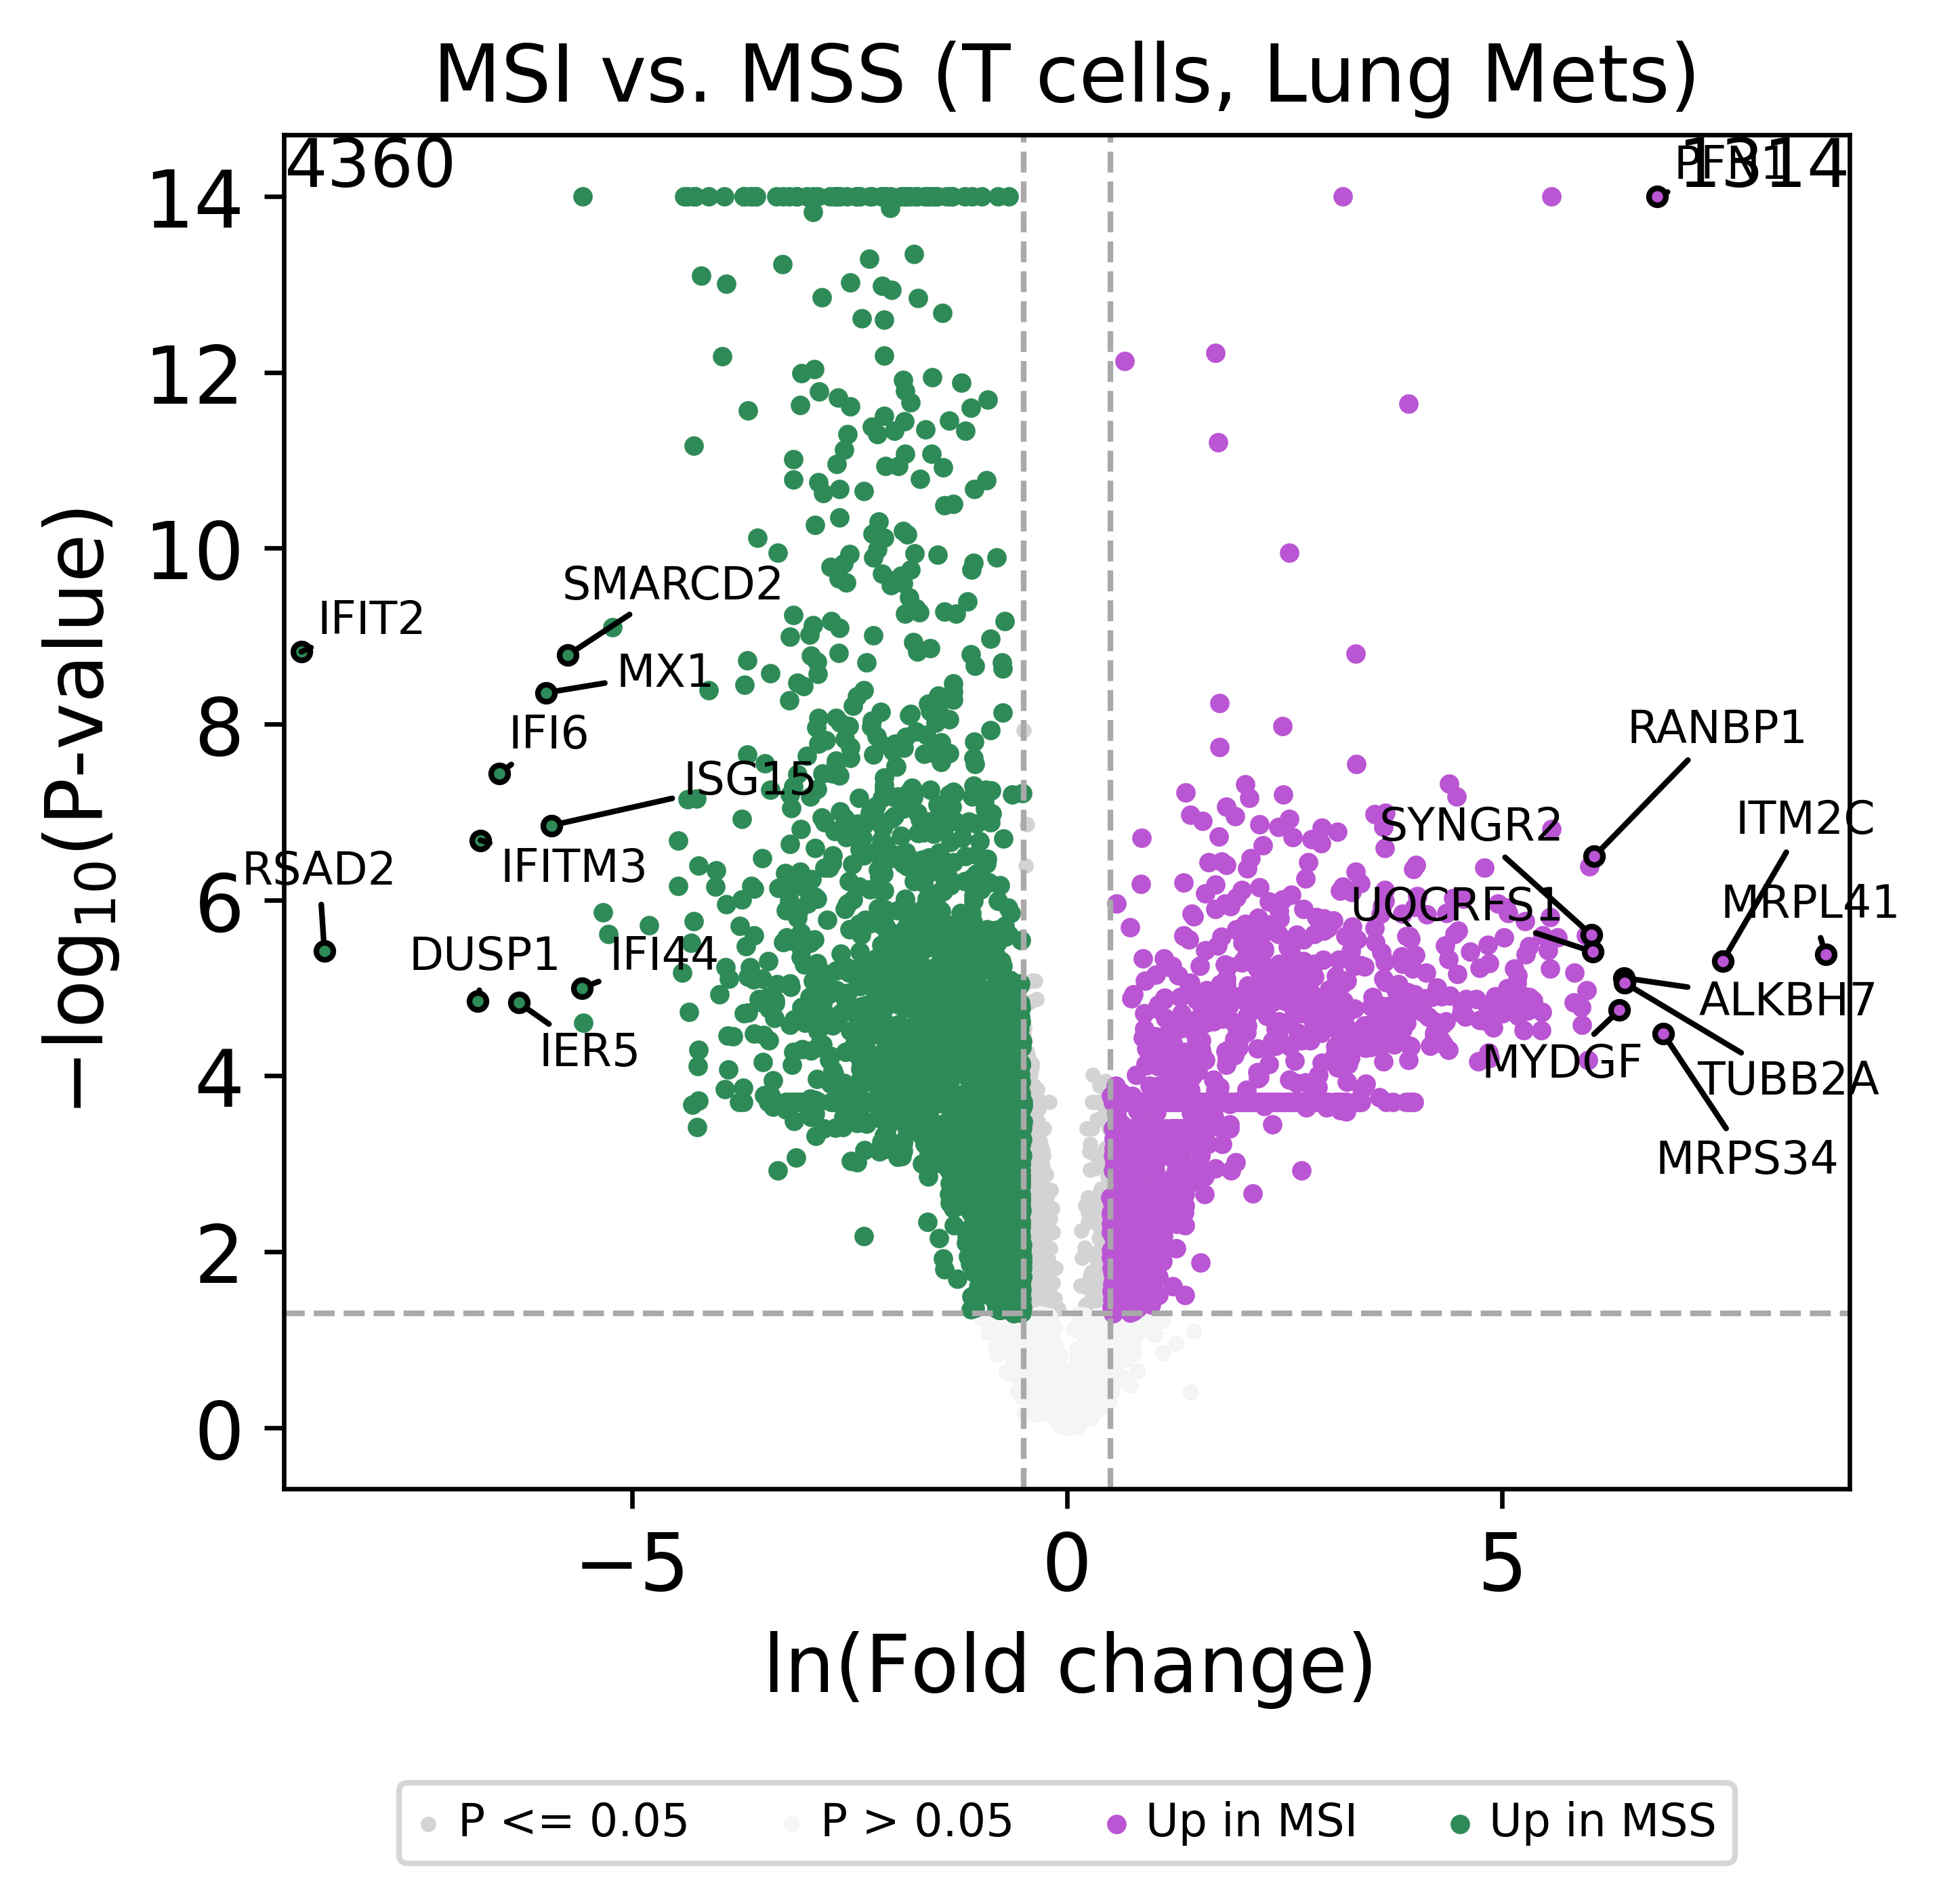

In [54]:
sc.settings.set_figure_params(dpi=300, dpi_save=500, figsize=(5,5), facecolor='white')

from adjustText import adjust_text

plot_df = result_1d.copy()

# plot settings
lfc_thresh = 0.5 # the lfc threshold for coloring the genes
point_size = 3 # how big to make the points? signif points are double the size
font_size = 8 # how big to make the labels?
label_n = 10 # how many to label?

up_color = 'mediumorchid'
down_color = 'seagreen'

# which group is which?
g1_name = 'MSI'
g2_name = 'MSS'
title_extra = '(T cells, Lung Mets)' 

# maximum p-val for plotting:
pval_max = np.ceil(np.quantile(plot_df.log_de_pval, 0.99))
plot_df['log_de_pval'] = [x if x < pval_max else pval_max for x in plot_df['log_de_pval'].to_list()]

# get up-regulated genes 
up = plot_df.loc[(plot_df.de_pval <= 0.05) & (plot_df.de_coef >= lfc_thresh)]
up_label = up.sort_values('de_coef').tail(label_n)

# get down-regulated genes
down = plot_df.loc[(plot_df.de_pval <= 0.05) & (plot_df.de_coef < -1*lfc_thresh)]
down_label = down.sort_values('de_coef').head(label_n)

# gent genes that did not reach significance
not_signif = plot_df.loc[(plot_df.de_pval > 0.05)]

# calculate the plot min / max size 
plot_max = np.abs(plot_df.de_coef).max() + 0.2

# initialize plot
fig, ax = plt.subplots()

# plot all genes
plt.scatter(
    x = plot_df.de_coef,
    y = plot_df.log_de_pval,
    color = 'lightgrey',
    label = 'P <= 0.05',
    s = point_size
)

# add horizontal lines
plt.axvline(-1*lfc_thresh,color="darkgrey",linestyle="--", linewidth=1)
plt.axvline(lfc_thresh,color="darkgrey",linestyle="--", linewidth=1)
plt.axhline(-1*np.log10(0.05),color="darkgrey",linestyle="--", linewidth=1)

# plot non-signif genes 
plt.scatter(
    x = not_signif.de_coef,
    y = not_signif.log_de_pval,
    color = 'whitesmoke',
    label = 'P > 0.05',
    s = point_size
)

# plot upregulated genes:
plt.scatter(
    x = up.de_coef,
    y = up.log_de_pval,
    label = "Up in {}".format(g1_name),
    color = up_color,
    s = point_size * 2
)


# plot upregulated labeled genes:
plt.scatter(
    x = up_label.de_coef,
    y = up_label.log_de_pval,
    color = up_color,
    edgecolors='black',
    s = point_size * 3
)

# plot downregulated genes:
plt.scatter(
    x = down.de_coef,
    y = down.log_de_pval,
    label = "Up in {}".format(g2_name),
    color = down_color,
    s = point_size * 2
)

# plot downregulated labeled genes:
plt.scatter(
    x = down_label.de_coef,
    y = down_label.log_de_pval,
    color = down_color,
    edgecolors='black',
    s = point_size * 3
)

# annotate upreg genes
texts = [ax.text(x=r['de_coef'],y=r['log_de_pval'], s=r['gene'], fontsize=font_size) for i,r in up_label.iterrows()]
adjust_text(texts, expand=(1.2, 2), # expand text bounding boxes by 1.2 fold in x direction and 2 fold in y direction
            arrowprops=dict(arrowstyle='-', color='black') # ensure the labeling is clear by adding arrows
            );

# annotate downreg genes
texts = [ax.text(x=r['de_coef'],y=r['log_de_pval'], s=r['gene'], fontsize=font_size) for i,r in down_label.iterrows()]
adjust_text(texts, expand=(1.2, 2), # expand text bounding boxes by 1.2 fold in x direction and 2 fold in y direction
            arrowprops=dict(arrowstyle='-', color='black') # ensure the labeling is clear by adding arrows
            );

# annotate the number of signif DEGs on each side
ax.annotate(down.shape[0] , xy=(0, 1), xycoords='axes fraction', fontsize=12,
                horizontalalignment='left', verticalalignment='top')
ax.annotate(up.shape[0] , xy=(1, 1), xycoords='axes fraction', fontsize=12,
                horizontalalignment='right', verticalalignment='top')

# remove gridlines
plt.grid(False)

# axis labels:
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
plt.xlabel("$log_{2}$(Fold change)")
plt.xlabel("$ln$(Fold change)")
plt.ylabel("$-log_{10}$(P-value)")

# set axis limits
plt.xlim([-1*plot_max, plot_max])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4, fontsize=8)

# set the plot title:
plt.title('{} vs. {} {}'.format(g1_name, g2_name, title_extra))

plt.tight_layout()


## Enrichment analysis with GSEApy